# Monthly Corn Price Forecasting using ARIMA

In [1]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
# import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA

## 1. Data Import and Cleanup

In [2]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1': '2020-11-30']
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
corn_act_prices.head(3)

,Corn_Price
Date,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300


In [3]:
# Drop nulls from Corn DataFrame
corn_act_prices.dropna(inplace=True)

In [4]:
# Checking Timestamp
type(corn_act_prices.index[3])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
# Creating Monthly data from the daily data
monthly_corn_data = corn_act_prices["Corn_Price"].resample('M').mean().to_frame()
# Save the monthly corn data without NA values into a csv file
monthly_corn_data.to_csv("../Resources/monthly_corn_data.csv")
# Display some sample
monthly_corn_data ,  monthly_corn_data.shape

(            Corn_Price
 Date                  
 2000-01-31    2.159875
 2000-02-29    2.205350
 2000-03-31    2.306848
 2000-04-30    2.283895
 2000-05-31    2.395114
 ...                ...
 2020-07-31    3.311591
 2020-08-31    3.262881
 2020-09-30    3.662738
 2020-10-31    3.988977
 2020-11-30    4.163025
 
 [251 rows x 1 columns],
 (251, 1))

In [6]:
# Drop nulls from Corn DataFrame
monthly_corn_data.dropna(inplace=True)

In [7]:
# Cheking a sample
monthly_corn_data.tail()

,Corn_Price
Date,
2020-07-31,3.311591
2020-08-31,3.262881
2020-09-30,3.662738
2020-10-31,3.988977
2020-11-30,4.163025


In [8]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
monthly_corn_data.dtypes, monthly_corn_data.count(), monthly_corn_data.isnull().sum(), monthly_corn_data.shape

(Corn_Price    float64
 dtype: object,
 Corn_Price    251
 dtype: int64,
 Corn_Price    0
 dtype: int64,
 (251, 1))

## 2. Creating Training and Validation Datasets

In [9]:
# Trim the datasets to have Training data (80%: 20% split)
corn_df_tr = monthly_corn_data.loc['2000-01-31':'2016-8-31']
corn_df_val = monthly_corn_data.loc['2016-9-1': :]
# Data Checks
corn_df_tr.tail(), corn_df_tr.shape, corn_df_val.head(), corn_df_val.shape

(            Corn_Price
 Date                  
 2016-04-30    3.729810
 2016-05-31    3.908333
 2016-06-30    4.107432
 2016-07-31    3.447875
 2016-08-31    3.240696,
 (200, 1),
             Corn_Price
 Date                  
 2016-09-30    3.337500
 2016-10-31    3.494881
 2016-11-30    3.460452
 2016-12-31    3.535952
 2017-01-31    3.618125,
 (51, 1))

In [10]:
# Checking data
corn_df_tr.dtypes, corn_df_tr.count(), corn_df_tr.isnull().sum(), corn_df_tr.shape

(Corn_Price    float64
 dtype: object,
 Corn_Price    200
 dtype: int64,
 Corn_Price    0
 dtype: int64,
 (200, 1))

## 3. Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the closing price into a trend and noise.

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Corn Price" into two separate series:
ts_noise_corn, ts_trend_corn = sm.tsa.filters.hpfilter(corn_df_tr["Corn_Price"])

In [12]:
# Create dataframes of just the exchange rate price, and add columns for "noise" and "trend" series from above:
corn_df_tr["ts_noise_corn"] = ts_noise_corn
corn_df_tr["ts_trend_corn"] = ts_trend_corn

corn_df_tr.reset_index()

corn_df_hpf = corn_df_tr[["Corn_Price", "ts_noise_corn", "ts_trend_corn"]]
# Data Sample Checks
corn_df_hpf.tail()

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Corn_Price,ts_noise_corn,ts_trend_corn
Date,,,
2016-04-30,3.729810,0.102637,3.627173
2016-05-31,3.908333,0.287527,3.620807
2016-06-30,4.107432,0.493552,3.613880
2016-07-31,3.447875,-0.158531,3.606406
2016-08-31,3.240696,-0.358013,3.598708


In [13]:
# Data Checks
corn_df_hpf.dtypes

Corn_Price       float64
ts_noise_corn    float64
ts_trend_corn    float64
dtype: object

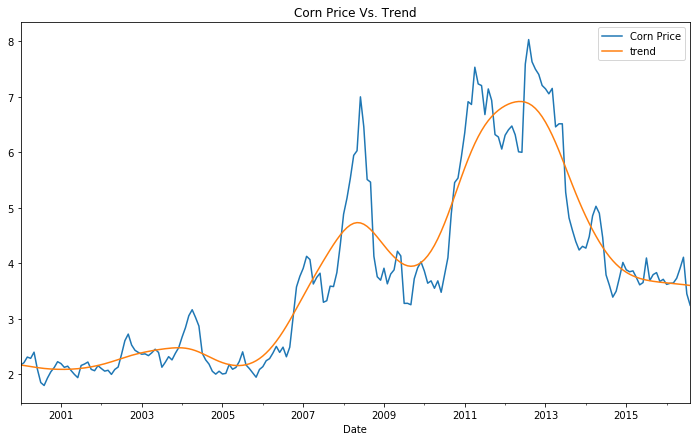

In [14]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_trend_corn.plot(label = 'trend', title='Corn Price Vs. Trend', figsize=(12,7),legend = True);

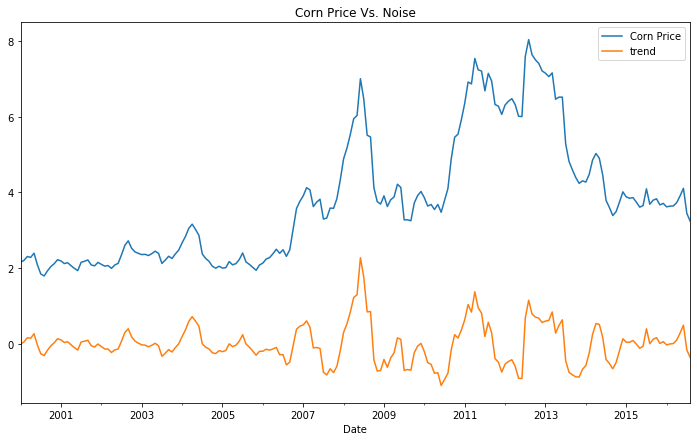

In [15]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_noise_corn.plot(label = 'trend', title='Corn Price Vs. Noise', figsize=(12,7),legend = True);

## 4. Variable Selection for the ARIMA Model

Comparing Absolute Corn Price versus percent change metrics to conclude which variable is better fit for model development 

In [16]:
# Creating percent change of the Adj Close 
corn_returns = (corn_df_tr[['Corn_Price']].pct_change()).replace(-np.inf, np.nan).dropna()
corn_returns.tail()

,Corn_Price
Date,
2016-04-30,0.023842
2016-05-31,0.047864
2016-06-30,0.050942
2016-07-31,-0.160576
2016-08-31,-0.060089


In [17]:
# Checking data
corn_returns.dtypes, corn_returns.count(), corn_returns.isnull().sum()

(Corn_Price    float64
 dtype: object,
 Corn_Price    199
 dtype: int64,
 Corn_Price    0
 dtype: int64)

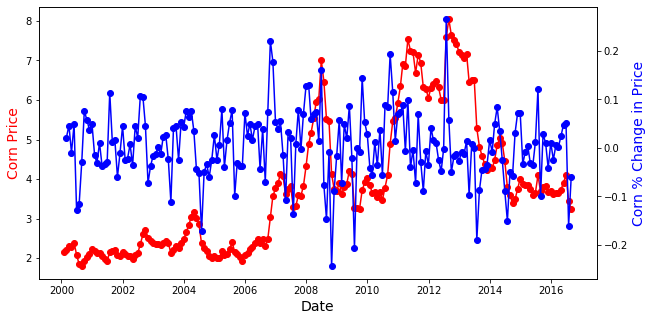

In [18]:
# Plotting the Absolute Corn price versus % change in the Corn price to determine which data should be used in
# modelling exercise

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize= (10,5))
# make a plot
ax.plot(corn_df_tr.index, corn_df_tr['Corn_Price'], color="red", marker="o")
# # set x-axis label
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Corn Price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(corn_returns.index, corn_returns['Corn_Price'],color="blue",marker="o")
ax2.set_ylabel("Corn % Change in Price",color="blue",fontsize=14)
plt.show()

From the above graphs it is evident that % change in the corn prices is more stationary than the absolute corn price and hence, should be used in ARIMA modelling

## 5. Autocorrelation & Partial Autocorrelation Analysis

Use the autocorrelation and partial autocorrelation data to get a sense of how many lags to use in the ARIMA models

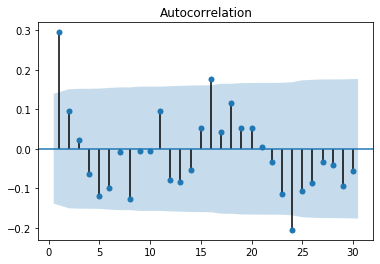

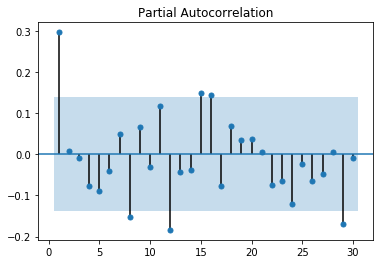

In [19]:
# Import ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(corn_returns['Corn_Price'], lags=30, zero=False)
plot_pacf(corn_returns['Corn_Price'], lags=30, zero=False);

ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Basically, how well the present value of the series is related to its past values. While, PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.

Both ACF and PACF can be used to identify the orders of AR and MA terms in the ARMA model.

From the above ACF plot we notice that 1-2 lags could potentialy useful while PACF is significant at the 4-5 lags are outside the default confidence interval of 95%. Hence, we will play with p and q accordingly to create the ARIMA models.

## 6. Forecasting Corn Returns using an ARIMA Model

In [20]:
# Estimate ARIMA Model:
model = ARIMA(corn_returns['Corn_Price'], order=(1, 1,1))
# Fit the model
results = model.fit()
# save model
results.save("../Model_Results/Monthly_ARIMA_model.pkl")

from statsmodels.tsa.arima_model import ARIMAResults
# load model
loaded = ARIMAResults.load("../Model_Results/Monthly_ARIMA_model.pkl")
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Corn_Price   No. Observations:                  198
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 246.972
Method:                       css-mle   S.D. of innovations              0.069
Date:                Tue, 08 Dec 2020   AIC                           -485.944
Time:                        11:51:24   BIC                           -472.791
Sample:                    03-31-2000   HQIC                          -480.620
                         - 08-31-2016                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -8.069e-05      0.000     -0.672      0.502      -0.000       0.000
ar.L1.D.Corn_Price     0.2988      0.068      4.383      0.000       0.165       0.432
ma.L1.D.Corn_Price    -1.0000      0.016    -64.111      0.000      -1.031      -0.969
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.3471           +0.0000j            3.3471            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
# #Getting the forecasted values of the adjusted closing price
corn_forecasted_values=np.array(1+ results.forecast(steps=51)[0])
for i in range(1, len(corn_forecasted_values)):
    corn_forecasted_values[i] = corn_forecasted_values[i]*corn_forecasted_values[i-1]
corn_forecasted_values = corn_forecasted_values*corn_act_prices.loc['2016-08-31']['Corn_Price']
corn_forecasted_values

array([3.06319768, 3.03684292, 3.02124926, 3.00869586, 2.99690508,
       2.98520237, 2.97338889, 2.96140734, 2.94924259, 2.93689204,
       2.92435688, 2.91163944, 2.89874241, 2.88566861, 2.87242093,
       2.85900227, 2.8454156 , 2.83166388, 2.81775013, 2.80367737,
       2.78944865, 2.77506704, 2.76053565, 2.7458576 , 2.73103601,
       2.71607405, 2.70097488, 2.6857417 , 2.67037771, 2.65488612,
       2.63927018, 2.6235331 , 2.60767816, 2.59170861, 2.57562772,
       2.55943877, 2.54314505, 2.52674983, 2.51025641, 2.4936681 ,
       2.47698817, 2.46021994, 2.4433667 , 2.42643173, 2.40941835,
       2.39232983, 2.37516946, 2.35794052, 2.34064629, 2.32329001,
       2.30587497])

## 7. Validation of the Corn

In [22]:
# Getting the array of the actual corn price
corn_actual_val = np.array(corn_df_val["Corn_Price"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(corn_actual_val) - np.array(corn_forecasted_values))
corn_avg_error = sum(abs_change)/ len(abs_change)
# Compute the mean square error
mse = sum(abs_change**2)/len(abs_change)
# Printing the average error term and MSE
print(f"The Average Error Term of our forecasts is: {round(corn_avg_error,2)}"), print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))

The Average Error Term of our forecasts is: 0.97
The Mean Squared Error of our forecasts is 1.058


(None, None)

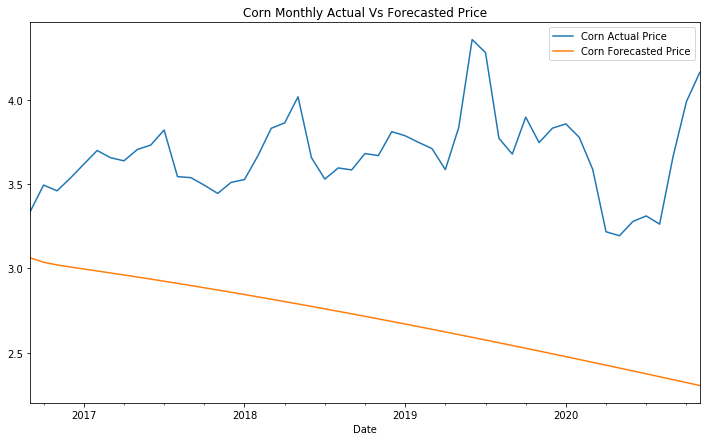

In [23]:
# Combining Date,Actual and Predicted Adj Closing price for Corn 
Corn_Comp1 = pd.DataFrame({'Date': corn_df_val.index.values, 'Corn_Actual_Price': corn_actual_val, 'Corn_Forecasted_Price': corn_forecasted_values}, columns=['Date', 'Corn_Actual_Price', 'Corn_Forecasted_Price'])
Corn_Comp= Corn_Comp1.set_index("Date")
# Plot the variation of model
Corn_Comp["Corn_Actual_Price"].plot(label = 'Corn Actual Price', figsize=(10,6),legend = True)
Corn_Comp["Corn_Forecasted_Price"].plot(label = 'Corn Forecasted Price', title='Corn Monthly Actual Vs Forecasted Price', figsize=(12,7),legend = True);
plt.savefig("../Images/Monthly_Corn_Actual_Forecasted.png")

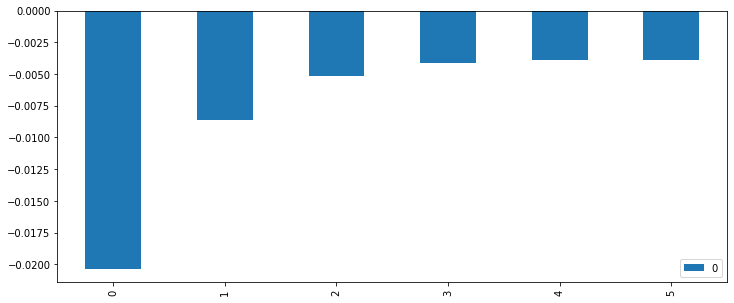

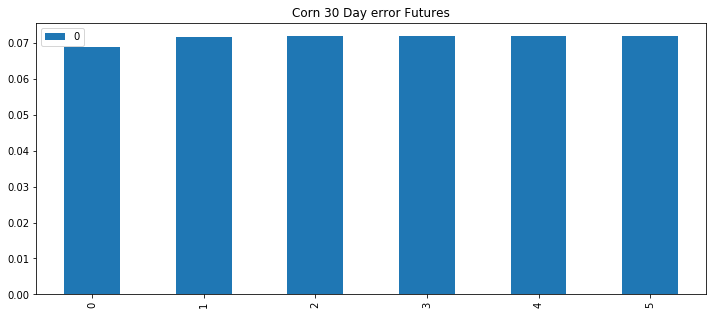

In [24]:
# Plot the 6 month of Closing Price Forecast
pd.DataFrame(results.forecast(steps=6)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=6)[1]).plot(kind='bar',title="Corn 30 Day error Futures",figsize=(12,5),legend = True);